### Rain in Australia
Importacions de les llibrerias utilitzades

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ipywidgets as widgets
import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_recall_curve, average_precision_score, \
    roc_auc_score, roc_curve, auc, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
import scipy.stats
from scipy import stats
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from xgboost import XGBClassifier

pd.set_option("display.max_columns", None)


In [ ]:
database = pd.read_csv('../../data/weatherAUS.csv')

database.info()

In [ ]:
database.head()

In [ ]:
database.describe()

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(database.isnull(), yticklabels = False, cbar=False, cmap='gray')

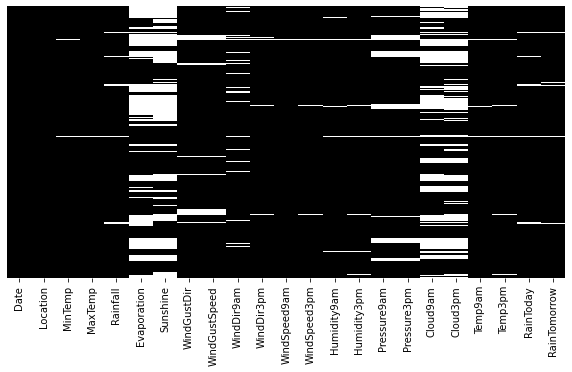

In [ ]:
# Checking data for NaN
missing = pd.DataFrame(database.isnull().sum().sort_values(ascending=False), columns=['No. of missing values'])
missing['% missing_values'] = (missing/len(database)).round(2)*100
missing

In [ ]:
database.duplicated().sum()

In [ ]:
database['RainTomorrow'].value_counts()

In [ ]:
targetNulls = widgets.ToggleButtons(
    options=['No', 'Yes', 'Delete'],
    description='Optios:',
    disabled=False,
    tooltips=['No', 'Yes', 'Delete']
)
display(targetNulls)
    
def changeValues(obj):
    database = pd.read_csv('../../data/weatherAUS.csv')
    if(targetNulls.value == 'No'):
        database['RainTomorrow'] = [1 if i=='Yes' else 0 for i in database['RainTomorrow'] ]
    elif(targetNulls.value == 'Yes'):
        database['RainTomorrow']=[0 if i=='No' else 1 for i in database['RainTomorrow'] ]
    else:
        database = database.dropna(axis=0, subset=['RainTomorrow'])
    print("Opcio escollida:", targetNulls.value)
    print(database['RainTomorrow'].value_counts())
    print("--------------------------------------")
    
        
targetNulls.observe(changeValues, 'value')
cols_to_drop=['Date']
database.drop(columns=cols_to_drop,inplace=True)

In [ ]:
f, ax = plt.subplots(figsize=(6, 8))
ax = sns.countplot(x="RainTomorrow", data=database, palette="Set2")
plt.show()

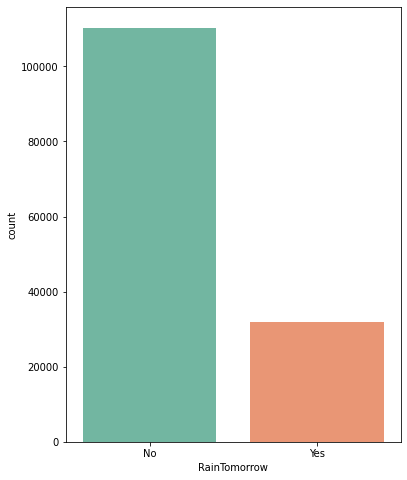

In [ ]:
balance = widgets.ToggleButtons(
    options=['Oversampling', 'Subsampling', 'None'],
    description='Optios:',
    disabled=False,
    tooltips=['Oversampling', 'Subsampling', 'None']
)
print("Balanceig de les dades")
balance

In [ ]:
count_class_0, count_class_1 = database.RainTomorrow.value_counts()
if(balance.value == 'Oversampling'):
    df_class_0 = database[database['RainTomorrow'] == "No"]
    df_class_1 = database[database['RainTomorrow'] == "Yes"]
    
    df_class_1_over = df_class_1.sample(count_class_0, replace=True)
    database = pd.concat([df_class_0, df_class_1_over], axis=0)
    
    
elif(balance.value == 'Subsampling'):
    df_class_0 = database[database['RainTomorrow'] == "No"]
    df_class_1 = database[database['RainTomorrow'] == "Yes"]

    df_class_0_under = df_class_0.sample(count_class_1)
    database = pd.concat([df_class_0_under, df_class_1], axis=0)

In [ ]:
f, ax = plt.subplots(figsize=(6, 8))
ax = sns.countplot(x="RainTomorrow", data=database, palette="Set2")
plt.show()

In [ ]:
x=database.drop(['RainTomorrow'],axis=1)
y=database['RainTomorrow']
print(x.shape,y.shape)

In [ ]:
categorical_cols = list(x.select_dtypes(include=['object']).columns)
continuous_cols = list(x.select_dtypes(include=['float64']).columns)

atributeNulls = widgets.ToggleButtons(
    options=['Mode', 'Median', 'Mean'],
    description='Optios:',
    disabled=False,
    tooltips=['Mode', 'Median', 'Mean']
)
display(atributeNulls)
    
def changeValues(obj):
    x=database.drop(['RainTomorrow'],axis=1)
    for i in categorical_cols:
        x[i].fillna(x[i].mode()[0], inplace=True)
        
    if(targetNulls.value == 'Mode'):
        for column in continuous_cols:
            x[column].fillna(x[column].mode()[0], inplace = True)
            
    elif(targetNulls.value == 'Median'):
        
        for column in continuous_cols:
            x[column].fillna(x[column].median(), inplace = True)
    else:
        for column in continuous_cols:
            x[column].fillna(x[column].mean(), inplace = True)
    print("Opcio escollida per als atribusc continues:", atributeNulls.value)
    print("--------------------------------------")
    
        
atributeNulls.observe(changeValues, 'value')

In [ ]:
transformer = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse='False',drop='first'), categorical_cols)],remainder='passthrough')
x=transformer.fit_transform(x)

In [ ]:
transformer.named_transformers_['ohe'].get_feature_names()

In [ ]:


def check_skewness(x):
    
    skew_limit=0.75
    skew_value=x[x.columns].skew()
    skew_cols=skew_value[abs(skew_value)>skew_limit]
    #print(skew_cols)
    cols=skew_cols.index
    return cols
    
skewed_col=check_skewness(x)
print(skewed_col)
pt=PowerTransformer(standardize=False)
x[skewed_col]=pt.fit_transform(x[skewed_col])


In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(x.isnull(), yticklabels = False, cbar=False, cmap='gray')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [ ]:
def evaluate(model):
    print(model)
    model.fit(X_train,y_train)
    accuracy=model.score(X_test,y_test)
    
    print('model name ',model)
    print('accuracy ',accuracy)

lr=LogisticRegression()
svm=SVC()
dt=DecisionTreeClassifier(max_depth=6)
rf=RandomForestClassifier(max_samples=0.9)
knn=KNeighborsClassifier(n_neighbors=5)

models=[lr,dt,rf,knn]

for model in models:
    evaluate(model)